# DQN实战

## Q-learning回顾


## CartPole环境
CartPole状态是连续的，动作值是离散的。

**状态参数（每个维度都是连续值）**
维度	意义	最小值	最大值
0	车的位置	-2.4	2.4
1	车的速度	-Inf	Inf
2	杆的角度	~ -41.8°	~ 41.8°
3	杆尖端的速度	-Inf	Inf


动作参数（离散）：
标号	动作
0	向左移动小车
1	向右移动小车

reward设置
在 CartPole 环境中，有一辆小车，智能体的任务是左右移动来保持车上的杆竖直，若杆子倾斜度数过大或车子离初始位置左右偏离程度过大，或者坚持时间到达两百帧，则游戏结束。在游戏中每坚持一帧，智能体能获得 1 的奖励，所以坚持时间越长，则最后的分数越高，最多便是坚持两百帧。

## DQN
由于每个维度状态是连续的，我们无法使用表格记录，一个常用的解决方法是函数拟合(Function Approximation）。由于神经网络强大的表达能力，我们可以用一个神经网络来表示$Q$函数。
- 若动作是无限的，神经网络输入状态$s$和动作$a$，然后输出一个标量，表示状态$s$下采取的动作$a$的价值。
- 若动作是有限的，除了上述方法外，还可以只输入$s$，输出每一个动作的$Q$


但通常DQN只能处理有限动作的情况，因为在$Q$函数更新过程中有 max 操作。假设神经网络用来拟合$Q$函数的参数是$w$，经每个状态$s$下所有可能的动作的$a$的$Q$值表示为$Q_w(s,a)$。

由于使用神经网络来拟合$Q$函数，我们称之为$Q$网络。那么网络$Q$的损失函数是什么呢？

回顾Q-learning的更新规则：
$$
Q\left(s_{t}, a_{t}\right) \leftarrow Q\left(s_{t}, A_{t}\right)+\alpha\left[r_{t}+\gamma \max _{a} Q\left(s_{t+1}, a\right)-Q\left(s_{t}, a_{t}\right)\right]
$$

是用TD目标$r+\gamma max_{a^}$ 


![](https://gitee.com/wubmu/image/raw/master/img/20210827165528.png)

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class ReplayBuffer:
    """经验回放池"""
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen= capacity) # 队列，先进先去
        
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done)) # 将数据加入buffer
        
    def sample(self, batch_size): # 从buffer 中采样数据，数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions) # zip(tanditons) 包含tuple的list, zip(*)各个tuple
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self): # 目前buffer中的数据量
        return len(self.buffer)
    

In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class DQN:
    """DQN算法"""
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) # Q网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) # 目标网络
        self.optimizer= torch.optim.Adam(self.q_net.parameters(), lr=learning_rate) # 使用Adam优化器
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-greedy
        self.target_update = target_update # 目标网络更新频率
        self.count = 0 # 计数器，记录更新次数
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(device)
            action = self.q_net(state).argmax().item()  # 动作索引的
        return action
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(device)
        
        
        q_values = self.q_net(states).gather(1, actions) # batch 下每个action对应的值[batch,actions]
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) # 下一个状态的最大Q值 dim是max函数索引的维度0/1，0是每列的最大值，1是每行的最大值
        q_targets = rewards + self.gamma * max_next_q_values * (1-dones) # TD目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) # 均方差误差损失函数
        self.optimizer.zero_grad()
        dqn_loss.backward() # 反向传播更新参数
        self.optimizer.step()
        
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) # 更新目标网络
        self.count += 1
        

Episode: 50, Score: 9.3
Episode: 100, Score: 12.3
Episode: 150, Score: 123.0
Episode: 200, Score: 163.1
Episode: 250, Score: 191.0
Episode: 300, Score: 198.1
Episode: 350, Score: 193.2
Episode: 400, Score: 200.0
Episode: 450, Score: 192.3
Episode: 500, Score: 200.0


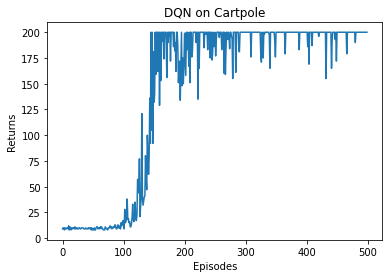

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []
for i_episode in range(num_episodes):
    episode_return = 0 
    state = env.reset()
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done,_ = env.step(action)
        
        replay_buffer.add(state, action, reward, next_state, done)
        episode_return += reward    # 这里的会报的计算不计算折扣因子衰减
        state = next_state
        
        if replay_buffer.size() > minimal_size: # 当buffer数据量超过一定值后，才进行Q网络训练
            b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
            transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
            agent.update(transition_dict)
    return_list.append(episode_return)
    if (i_episode + 1)%50 == 0:
        print("Episode: {}, Score: {}".format(i_episode+1, np.mean(return_list[-10:])))
        
        
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format('Cartpole'))
plt.show()


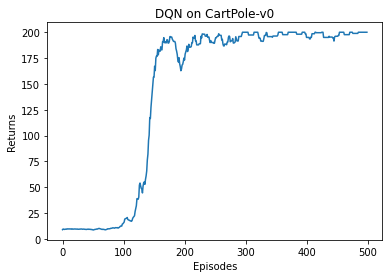

In [6]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()